In [10]:
import pandas as pd
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from datetime import timedelta
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy as np
import matplotlib.pyplot as plt

In [11]:
metal = "Gold"

In [36]:
df = pd.read_csv(f"../data/csv/{metal}_Data.csv",index_col="Business_Week")
df = df.drop(df.columns[0],axis=1)
df = df.drop(df.columns[9],axis=1)
df = df.dropna(axis=1)
# Makes graphs easier to interpret and match up. This is unimportent for
# this model.
df["Date"] = pd.to_datetime(df["Date"],infer_datetime_format=True)
df = df.reset_index(drop=True)
for i in range(len(df.index)):
    if df["Date"][i].weekday() != 1:
        if((df["Date"][i]+timedelta(days=1)).weekday() == 1):
            df.at[i,"Date"] = df["Date"][i]+timedelta(days=1)
        else:
            df.at[i,"Date"] = df["Date"][i]-timedelta(days=1)
# print(df.iloc[29,:])
df.set_index("Date",inplace=True)
df = df.asfreq("W-TUE")
df = df.dropna()

In [37]:
len(df.columns)

17

In [34]:
df.tail()

,Gold_Settle,Gold_Volume,Gold_Prev. Day Open Interest,Date,Open Interest,Money Manager Shorts,Money Manager Longs,Producer/Merchant/Processor/User Longs,Producer/Merchant/Processor/User Shorts,Ten_Yr_Futures_Settle,Ten_Yr_Futures_Volume,Ten_Yr_Futures_Prev. Day Open Interest,USD_Change,USD_Settle,USD_Volume,USD_Prev. Day Open Interest,ZAR_Change,ZAR_Settle
Business_Week,,,,,,,,,,,,,,,,,,
"[2019-06-19, 2019-06-25]",1392.580,94.00,413095.40,2019-06-25,1014917.0,25908.0,255572.0,67900.0,190731.0,127.709375,1226378.00,3829693.6,-1.505,95.9146,26570.0,46420.0,-0.19175,14.48855
"[2019-06-26, 2019-07-02]",1406.920,275744.00,427034.20,2019-07-02,1031393.0,17327.0,258490.0,68320.0,205037.0,127.865625,1275367.60,3782872.2,0.626,95.9638,14437.8,43682.4,-0.28325,14.27985
"[2019-07-03, 2019-07-09]",1405.375,389188.25,426279.25,2019-07-09,1010098.0,24254.0,241396.0,69203.0,207701.0,127.628906,1351832.25,3749954.5,0.821,96.7262,11471.2,41304.8,0.05575,14.24630
"[2019-07-10, 2019-07-16]",1411.220,330835.00,366538.20,2019-07-16,1038695.0,28250.0,248138.0,85509.0,211517.0,127.125000,1351597.40,3759147.8,-0.054,96.6758,14858.2,42843.8,-0.21575,14.05680
"[2019-07-17, 2019-07-23]",1425.340,391184.60,330269.20,2019-07-23,1088147.0,28073.0,245590.0,93866.0,217199.0,127.496875,1137014.00,3796138.0,0.377,96.8954,17571.8,41641.0,-0.05900,13.99895


In [14]:
# weekly = df.loc[[False if day.weekday() == 1 else True for day in df["Date"]]]
# weekly["Date"]

In [15]:
scaler_body = MinMaxScaler()
scaler_gold = MinMaxScaler()
scaler_body.fit(df.drop(f"{metal}_Settle",axis=1))
scaler_gold.fit(pd.DataFrame(df[f"{metal}_Settle"]))
normalized_df = [list(x) for x in scaler_body.transform(df.drop(f"{metal}_Settle",axis=1))]
normalized_gold = [list(x) for x in scaler_gold.transform(pd.DataFrame(df[f"{metal}_Settle"]))]
for i in range(len(normalized_gold)):
    normalized_gold[i].extend(normalized_df[i])
normalized_df = pd.DataFrame(normalized_gold,index=df.index,columns=df.columns)
normalized_df.head()

,Gold_Settle,Gold_Volume,Gold_Prev. Day Open Interest,Open Interest,Money Manager Shorts,Money Manager Longs,Producer/Merchant/Processor/User Longs,Producer/Merchant/Processor/User Shorts,Ten_Yr_Futures_Settle,Ten_Yr_Futures_Volume,Ten_Yr_Futures_Prev. Day Open Interest,USD_Change,USD_Settle,USD_Volume,USD_Prev. Day Open Interest,ZAR_Change,ZAR_Settle
Date,,,,,,,,,,,,,,,,,
2006-06-13,0.025239,0.000747,0.383462,0.000000,0.158664,0.181376,0.110468,0.206973,0.049919,0.008508,0.281443,0.787799,0.447752,0.078327,0.197709,0.459380,0.019160
2006-06-20,0.000000,0.000176,0.387091,0.011063,0.158911,0.148317,0.149656,0.200634,0.022412,0.001683,0.301270,0.531603,0.462115,0.001387,0.189336,0.476894,0.033710
2006-06-27,0.010690,0.000115,0.383627,0.002617,0.165892,0.134482,0.157804,0.183612,0.000000,0.150305,0.344174,0.579557,0.455362,0.051387,0.078247,0.499683,0.080899
2006-07-04,0.018676,0.073945,0.603558,0.014729,0.156217,0.140274,0.154881,0.185874,0.006520,0.182248,0.349343,0.339053,0.431829,0.026630,0.049000,0.304073,0.057119
2006-07-11,0.049619,0.100020,0.514149,0.063109,0.141308,0.185238,0.206740,0.212732,0.012429,0.217757,0.345133,0.563426,0.424091,0.025320,0.046916,0.467820,0.058435


# Loses ~ 4% R^2, but reduces number of features by almost half
Can prune models with little correlation/ability to predict the Settle Price.

In [16]:
influence = normalized_df.corr()
normalized_df = normalized_df[list(influence.loc[abs(influence[f"{metal}_Settle"]) >= .3].index)]

In [17]:
normalized_df.head()

,Gold_Settle,Open Interest,Money Manager Longs,Producer/Merchant/Processor/User Longs,Producer/Merchant/Processor/User Shorts,Ten_Yr_Futures_Settle,USD_Volume,USD_Prev. Day Open Interest
Date,,,,,,,,
2006-06-13,0.025239,0.000000,0.181376,0.110468,0.206973,0.049919,0.078327,0.197709
2006-06-20,0.000000,0.011063,0.148317,0.149656,0.200634,0.022412,0.001387,0.189336
2006-06-27,0.010690,0.002617,0.134482,0.157804,0.183612,0.000000,0.051387,0.078247
2006-07-04,0.018676,0.014729,0.140274,0.154881,0.185874,0.006520,0.026630,0.049000
2006-07-11,0.049619,0.063109,0.185238,0.206740,0.212732,0.012429,0.025320,0.046916


In [18]:
X = normalized_df.drop(f"{metal}_Settle", axis=1)
y = normalized_df[f"{metal}_Settle"]

In [19]:
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, random_state=1)

In [20]:
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [0.001, 0.0001], 'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]},
                    {'kernel': ['poly'], "degree": [2,3,4],'gamma': [0.001, 0.0001], 'C': [1, 10, 100, 1000]}]
testy = GridSearchCV(SVR(cache_size=2000),tuned_parameters)

In [21]:
testy.fit(X_train,y_train)

C:\Users\benel\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=SVR(C=1.0, cache_size=2000, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'kernel': ['rbf'], 'gamma': [0.001, 0.0001], 'C': [1, 10, 100, 1000]}, {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}, {'kernel': ['poly'], 'degree': [2, 3, 4], 'gamma': [0.001, 0.0001], 'C': [1, 10, 100, 1000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [22]:
print(testy.best_params_)
print(testy.best_score_)

{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.8166848144328342


In [23]:
predictions = pd.DataFrame(testy.predict(X_test),index=X_test.index)

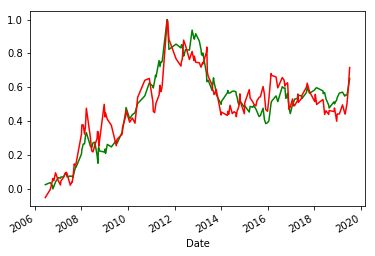

In [24]:
ax1 = y_test.plot(color="green")
ax2 = predictions[0].plot(color="red")

In [25]:
print(sqrt(mean_squared_error(y_test,predictions)))

0.0902582773832215


In [26]:
predictions_normal = pd.DataFrame(scaler_gold.inverse_transform(predictions),index=predictions.index)
y_test_normal = pd.DataFrame(scaler_gold.inverse_transform(pd.DataFrame(y_test)),index=y_test.index)

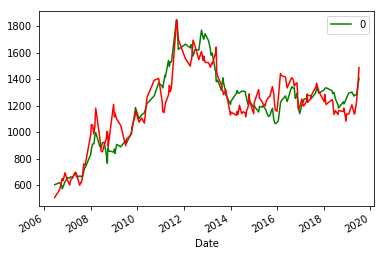

In [27]:
ax1 = y_test_normal.plot(color="green")
ax2 = predictions_normal[0].plot(color="red")

In [28]:
predictions_all = pd.DataFrame(testy.predict(X),index=X.index)
predictions_all = pd.DataFrame(scaler_gold.inverse_transform(predictions_all),index=predictions_all.index)
predictions_all.columns = ["Relative Value"]
predictions_all = predictions_all.reset_index()
predictions_all["Date"] = predictions_all["Date"].apply(lambda x: x + timedelta(days=3))
predictions_all.tail()

,Date,Relative Value
680,2019-06-28,1468.134923
681,2019-07-05,1485.198898
682,2019-07-12,1487.395014
683,2019-07-19,1494.268861
684,2019-07-26,1554.147135


In [30]:
# weekly = predictions_all.loc[[False if day.weekday() == 4 else True for day in predictions_all["Date"]]]
# weekly["Date"]

In [29]:
daily_transform_url = f"../data/csv/{metal}Prices.csv"
daily = pd.read_csv(daily_transform_url)[["Date","Settle"]]
daily["Date"] = pd.to_datetime(daily["Date"],infer_datetime_format=True)
daily = daily.merge(predictions_all,on="Date",how="left")
daily = daily.fillna(method="bfill")
daily = daily.dropna()
# daily = daily.iloc[:len(daily.index)-3]
daily.to_csv(f"../data/csv/{metal}_SVR_Daily.csv",index=False)
daily.tail(6)

,Date,Settle,Relative Value
3289,2006-06-23,584.8,490.385719
3290,2006-06-22,582.2,505.584107
3291,2006-06-21,587.5,505.584107
3292,2006-06-20,576.9,505.584107
3293,2006-06-19,568.8,505.584107
3294,2006-06-16,578.0,505.584107


In [30]:
weekly = daily.loc[[True if day.weekday() == 4 else False for day in daily["Date"]]]
weekly.to_csv(f"../data/csv/{metal}_SVR_Weekly.csv",index=False)
weekly.head()

,Date,Settle,Relative Value
3,2019-07-26,1419.3,1554.147135
8,2019-07-19,1426.7,1494.268861
13,2019-07-12,1412.2,1487.395014
18,2019-07-05,1400.1,1485.198898
22,2019-06-28,1413.7,1468.134923
